# Univariate Neural Network Speed Predictions

# Imports of Libraries and Datasets

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
!pip install tensorflow
!pip install tensorflow[and-cuda]
!pip install keras-tuner --upgrade
import keras_tuner as kt

zsh:1: no matches found: tensorflow[and-cuda]


In [4]:
#project_path = '/content/gdrive/MyDrive/Samhällsbyggnadsprogrammet/AH2179/Project/' # set your own project path
#df=pd.read_csv(project_path+'preprocessingV4.csv',sep=';') #Jennifers path
#project_path = '/content/gdrive/MyDrive/Project Applied AI/Data/' #Linneas path
train_df=pd.read_csv('/Users/algotsjoholm/Downloads/preprocessingV5.csv',sep=';')
train_df = train_df.dropna()

In [5]:
eval_df=pd.read_csv('/Users/algotsjoholm/Downloads/evalpreproV3.csv',sep=';') #change
eval_df = eval_df.dropna()
eval_df.describe()
#eval_df = eval_df[eval_df['PORTAL'] == 'E4S 58,140']

,Interval_1,FLOW_SUM,SPEED_WEIGHTED_AVG,FLOW_NEXT_15_SUM,FLOW_PREV_5_SUM,FLOW_PREV_15_SUM,FLOW_PREV_60_SUM,SPEED_NEXT_15_AVG,SPEED_PREV_5_AVG,SPEED_PREV_15_AVG,SPEED_PREV_60_AVG,IS_WEEKDAY,Interval_30
count,197436.000000,197436.000000,197436.000000,197436.000000,197436.000000,197436.000000,197436.000000,197436.000000,197436.000000,197436.000000,197436.000000,197436.000000,197436.000000
mean,442.061387,43.357093,19.925567,661.870155,215.871168,640.875985,2431.370778,19.844674,19.908797,19.935569,20.064293,0.687529,14.263331
std,82.307056,21.142930,2.362819,287.845567,100.108140,300.024576,1241.349348,2.135399,2.223883,2.132143,1.914030,0.463502,2.754295
min,299.000000,1.000000,0.560000,33.000000,8.000000,33.000000,100.000000,2.395607,1.685500,2.395607,4.005448,0.000000,9.000000
25%,371.000000,25.000000,18.976920,418.000000,124.000000,356.000000,1155.000000,18.948944,19.000403,19.017471,19.117466,0.000000,12.000000
50%,442.000000,48.000000,20.109010,770.000000,251.000000,755.000000,2923.000000,20.056423,20.137072,20.173206,20.325783,1.000000,14.000000
75%,513.000000,60.000000,21.216875,887.000000,295.000000,883.000000,3501.000000,21.083684,21.169776,21.186965,21.290345,1.000000,17.000000
max,584.000000,107.000000,35.560000,1254.000000,436.000000,1254.000000,4684.000000,24.257949,25.641731,24.576513,24.003175,1.000000,19.000000


In [6]:
train_df
#train_df = train_df[train_df['PORTAL'] == 'E4S 58,140']
#train_df  = train_df[(train_df['Interval_1'] > 450) & (train_df['Interval_1'] <=510)]

,PORTAL,Date,Interval_1,FLOW_SUM,SPEED_WEIGHTED_AVG,FLOW_NEXT_15_SUM,FLOW_PREV_5_SUM,FLOW_PREV_15_SUM,FLOW_PREV_60_SUM,SPEED_NEXT_15_AVG,SPEED_PREV_5_AVG,SPEED_PREV_15_AVG,SPEED_PREV_60_AVG,IS_WEEKDAY,Interval_30
59,"E4S 55,620",2021-06-01,299,46.0,21.201522,809.0,271.0,817.0,3031.0,20.327355,20.489483,20.748605,20.927258,1,9
60,"E4S 55,620",2021-06-01,300,52.0,20.211538,799.0,260.0,822.0,3054.0,20.400551,20.472538,20.694453,20.907895,1,10
61,"E4S 55,620",2021-06-01,301,43.0,19.920930,803.0,256.0,814.0,3071.0,20.416276,20.279102,20.584840,20.885396,1,10
62,"E4S 55,620",2021-06-01,302,51.0,19.504314,823.0,254.0,807.0,3084.0,20.347728,20.111063,20.494610,20.854199,1,10
63,"E4S 55,620",2021-06-01,303,51.0,20.606471,825.0,243.0,783.0,3101.0,20.304024,20.281975,20.542771,20.830094,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604005,"E4S 58,140",2021-12-31,580,18.0,21.883889,272.0,93.0,240.0,827.0,21.605846,21.622043,21.793375,21.557267,0,19
604006,"E4S 58,140",2021-12-31,581,11.0,21.212727,280.0,77.0,240.0,822.0,21.614643,21.765195,21.823500,21.566363,0,19
604007,"E4S 58,140",2021-12-31,582,15.0,21.908000,293.0,69.0,247.0,823.0,21.522355,21.808551,21.851660,21.582333,0,19
604008,"E4S 58,140",2021-12-31,583,16.0,20.883125,300.0,71.0,253.0,826.0,21.543433,21.670704,21.781344,21.582276,0,19


In [7]:
peak_eval_df=pd.read_csv('/Users/algotsjoholm/Downloads/peakevalpreproV2.csv',sep=';') #change
peak_eval_df = peak_eval_df.dropna()
peak_eval_df
#peak_eval_df = peak_eval_df[peak_eval_df['PORTAL'] == 'E4S 58,140']

,PORTAL,Date,Interval_1,FLOW_SUM,SPEED_WEIGHTED_AVG,FLOW_NEXT_15_SUM,FLOW_PREV_5_SUM,FLOW_PREV_15_SUM,FLOW_PREV_60_SUM,SPEED_NEXT_15_AVG,SPEED_PREV_5_AVG,SPEED_PREV_15_AVG,SPEED_PREV_60_AVG,IS_WEEKDAY,Interval_30
0,"E4S 55,620",2022-01-05,451,34.0,20.723529,535.0,183.0,528.0,2264.0,19.667645,19.924590,19.637822,19.783167,1,15
1,"E4S 55,620",2022-01-05,452,39.0,19.423846,542.0,194.0,535.0,2263.0,19.636033,19.861907,19.577645,19.760420,1,15
2,"E4S 55,620",2022-01-05,453,44.0,18.888636,532.0,195.0,550.0,2264.0,19.726297,19.685436,19.528818,19.752407,1,15
3,"E4S 55,620",2022-01-05,454,35.0,19.148571,535.0,193.0,541.0,2260.0,19.648710,19.564974,19.529261,19.732009,1,15
4,"E4S 55,620",2022-01-05,455,38.0,19.536842,524.0,190.0,549.0,2261.0,19.717195,19.504368,19.555647,19.708859,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41545,"E4S 58,140",2022-06-30,506,66.0,21.448182,919.0,330.0,946.0,3768.0,21.302590,21.522667,21.300666,21.365154,1,16
41546,"E4S 58,140",2022-06-30,507,50.0,20.661600,933.0,302.0,959.0,3760.0,21.347824,21.233344,21.265068,21.355133,1,16
41547,"E4S 58,140",2022-06-30,508,77.0,19.574805,921.0,317.0,970.0,3780.0,21.481379,21.013943,21.180227,21.318696,1,16
41548,"E4S 58,140",2022-06-30,509,49.0,22.113673,944.0,304.0,944.0,3757.0,21.406324,21.037599,21.176419,21.330000,1,16


# Model Creation

## Features and Normalization

In [8]:
features = [
    'FLOW_NEXT_15_SUM',
    'SPEED_NEXT_15_AVG',
    'FLOW_SUM',
    'SPEED_WEIGHTED_AVG',
    'FLOW_PREV_5_SUM',
    'FLOW_PREV_15_SUM',
    'FLOW_PREV_60_SUM',
    'SPEED_PREV_5_AVG',
    'SPEED_PREV_15_AVG',
    'SPEED_PREV_60_AVG',
    'IS_WEEKDAY',
    'Interval_30'
]

train_df = train_df[features]
#train_df = train_df.iloc[:30000]

x = train_df.drop(['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG'], axis=1)

#y = train_df[['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG']]
y = train_df['SPEED_NEXT_15_AVG']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler_x = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)


scaler_y = StandardScaler()
#y_train = scaler_y.fit_transform(y_train)
#y_test = scaler_y.transform(y_test)

## Find Best Hyperparameters

In [9]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    
    model.add(Dense(units=hp.Choice('l1_units', values=[32, 64, 128, 256]), 
                    activation=hp.Choice('activation_1', ['relu', 'tanh']),
                    input_dim=X_train.shape[1]))

    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(Dense(units=hp.Choice(f'l{i+2}_units', values=[32, 64, 128, 256]),
                        activation=hp.Choice(f'activation_{i+2}', ['relu', 'tanh'])))
        #model.add(Dropout(rate=hp.Choice(f'dropout_{i+2}', values=[0.0, 0.2])))

    #model.add(Dense(2))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='mae',
        metrics=['mae']
    )

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_mae',
                     max_epochs=50,
                     factor=3,
                     seed=42,
                     directory='my_dir',
                     project_name='tune_exponential_units12')

early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stop, reduce_lr])

Trial 90 Complete [00h 06m 46s]
val_mae: 0.31376808881759644

Best val_mae So Far: 0.31376808881759644
Total elapsed time: 01h 12m 36s


In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for hp_name, hp_value in best_hps.values.items():
    print(f"{hp_name}: {hp_value}")

l1_units: 32
activation_1: tanh
num_layers: 2
l2_units: 256
activation_2: tanh
learning_rate: 0.001996334459987542
l3_units: 256
activation_3: tanh
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


## Train Best Model

In [11]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stop, reduce_lr])

Epoch 1/50
9531/9531 ━━━━━━━━━━━━━━━━━━━━ 9s 950us/step - loss: 0.6860 - mae: 0.6860 - val_loss: 0.4864 - val_mae: 0.4864 - learning_rate: 0.0020
Epoch 2/50
9531/9531 ━━━━━━━━━━━━━━━━━━━━ 9s 894us/step - loss: 0.3877 - mae: 0.3877 - val_loss: 0.3717 - val_mae: 0.3717 - learning_rate: 0.0020
Epoch 3/50
9531/9531 ━━━━━━━━━━━━━━━━━━━━ 9s 947us/step - loss: 0.3783 - mae: 0.3783 - val_loss: 0.4223 - val_mae: 0.4223 - learning_rate: 0.0020
Epoch 4/50
9531/9531 ━━━━━━━━━━━━━━━━━━━━ 8s 857us/step - loss: 0.3741 - mae: 0.3741 - val_loss: 0.3893 - val_mae: 0.3893 - learning_rate: 0.0020
Epoch 5/50
9531/9531 ━━━━━━━━━━━━━━━━━━━━ 9s 892us/step - loss: 0.3717 - mae: 0.3717 - val_loss: 0.3759 - val_mae: 0.3759 - learning_rate: 0.0020
Epoch 6/50
9531/9531 ━━━━━━━━━━━━━━━━━━━━ 9s 926us/step - loss: 0.3495 - mae: 0.3495 - val_loss: 0.4047 - val_mae: 0.4047 - learning_rate: 9.9817e-04
Epoch 7/50
9531/9531 ━━━━━━━━━━━━━━━━━━━━ 8s 881us/step - loss: 0.3501 - mae: 0.3501 - val_loss: 0.3508 - val_mae: 0.350

In [12]:
pd.DataFrame(history.history)

,loss,mae,val_loss,val_mae,learning_rate
0,0.463981,0.463981,0.486423,0.486423,0.001996
1,0.384907,0.384907,0.371688,0.371688,0.001996
2,0.377952,0.377952,0.422313,0.422313,0.001996
3,0.374162,0.374162,0.389322,0.389322,0.001996
4,0.370061,0.370061,0.375938,0.375938,0.001996
5,0.350114,0.350114,0.404710,0.404710,0.000998
6,0.347492,0.347492,0.350829,0.350829,0.000998
7,0.347815,0.347815,0.339752,0.339752,0.000998
8,0.346324,0.346324,0.403379,0.403379,0.000998
9,0.346078,0.346078,0.335449,0.335449,0.000998


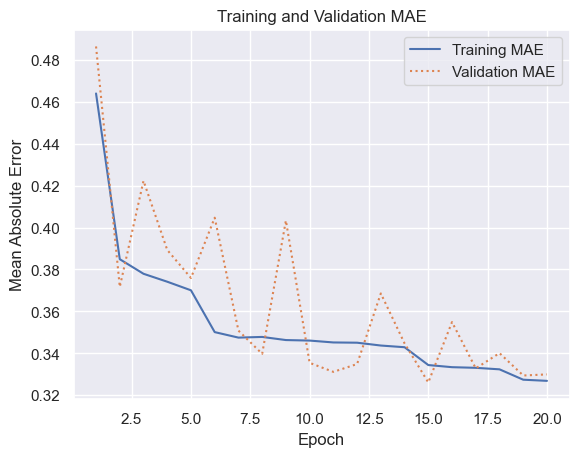

In [13]:
sns.set()

err = history.history['mae']
val_err = history.history['val_mae']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.show()

# Evaluation Results

## Evaluation on Test Split

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_model.predict(X_test)

#y_pred = scaler_y.inverse_transform(y_pred)
#y_test = scaler_y.inverse_transform(y_test)

'''mae_1 = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mse_1 = mean_squared_error(y_test[:, 0], y_pred[:, 0])
r2_1 = r2_score(y_test[:, 0], y_pred[:, 0])

# Calculate metrics for the second target variable (e.g., SPEED_NEXT_15_AVG)
mae_2 = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mse_2 = mean_squared_error(y_test[:, 1], y_pred[:, 1])
r2_2 = r2_score(y_test[:, 1], y_pred[:, 1])

# Optionally, calculate the overall mean of the MAE, MSE, and R^2 across both outputs
mae_avg = (mae_1 + mae_2) / 2
mse_avg = (mse_1 + mse_2) / 2
r2_avg = (r2_1 + r2_2) / 2

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")
print()
print(f"Target 2 - Mean Absolute Error (MAE): {mae_2}")
print(f"Target 2 - Mean Squared Error (MSE): {mse_2}")
print(f"Target 2 - R-squared (R^2): {r2_2}")
print()
print(f"Average MAE: {mae_avg}")
print(f"Average MSE: {mse_avg}")
print(f"Average R-squared: {r2_avg}")'''

mae_1 = mean_absolute_error(y_test, y_pred)
mse_1 = mean_squared_error(y_test, y_pred)
r2_1 = r2_score(y_test, y_pred)

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")


2979/2979 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step
--------------------------------------Result from the best model on test data ---------------------------------------------
Target 1 - Mean Absolute Error (MAE): 0.32766934677348586
Target 1 - Mean Squared Error (MSE): 0.468549152249028
Target 1 - R-squared (R^2): 0.8880966689210351


## Evaluation on Full Final Evaluation Dataset

In [15]:
eval_df = eval_df[features]

x_eval = eval_df.drop(['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG'], axis=1)
#y_eval = eval_df[['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG']]
y_eval = eval_df['SPEED_NEXT_15_AVG']

x_eval = scaler_x.transform(x_eval)

y_pred = best_model.predict(x_eval)

#y_pred = scaler_y.inverse_transform(y_pred)
#y_eval = scaler_y.inverse_transform(y_eval)

'''mae_1 = mean_absolute_error(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])
mse_1 = mean_squared_error(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])
r2_1 = r2_score(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])

# Calculate metrics for the second target variable (e.g., SPEED_NEXT_15_AVG)
mae_2 = mean_absolute_error(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])
mse_2 = mean_squared_error(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])
r2_2 = r2_score(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])

# Optionally, calculate the overall mean of the MAE, MSE, and R^2 across both outputs
mae_avg = (mae_1 + mae_2) / 2
mse_avg = (mse_1 + mse_2) / 2
r2_avg = (r2_1 + r2_2) / 2

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")
print()
print(f"Target 2 - Mean Absolute Error (MAE): {mae_2}")
print(f"Target 2 - Mean Squared Error (MSE): {mse_2}")
print(f"Target 2 - R-squared (R^2): {r2_2}")
print()
print(f"Average MAE: {mae_avg}")
print(f"Average MSE: {mse_avg}")
print(f"Average R-squared: {r2_avg}")'''

mae_1 = mean_absolute_error(y_eval, y_pred)
mse_1 = mean_squared_error(y_eval, y_pred)
r2_1 = r2_score(y_eval, y_pred)

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")


6170/6170 ━━━━━━━━━━━━━━━━━━━━ 2s 350us/step
--------------------------------------Result from the best model on test data ---------------------------------------------
Target 1 - Mean Absolute Error (MAE): 0.3687524791746071
Target 1 - Mean Squared Error (MSE): 0.7092683810975705
Target 1 - R-squared (R^2): 0.8444555263934723


## Evaluation on Peak Final Evaluation Dataset

In [16]:
eval_df_peak= peak_eval_df[features]

x_eval = eval_df_peak.drop(['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG'], axis=1)
#y_eval = eval_df_peak[['FLOW_NEXT_15_SUM', 'SPEED_NEXT_15_AVG']]
y_eval = eval_df_peak['SPEED_NEXT_15_AVG']

x_eval = scaler_x.transform(x_eval)

#y_pred = scaler_y.inverse_transform(y_pred)
#y_eval = scaler_y.inverse_transform(y_eval)

y_pred = best_model.predict(x_eval)

'''mae_1 = mean_absolute_error(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])
mse_1 = mean_squared_error(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])
r2_1 = r2_score(y_eval['FLOW_NEXT_15_SUM'], y_pred[:, 0])

# Calculate metrics for the second target variable (e.g., SPEED_NEXT_15_AVG)
mae_2 = mean_absolute_error(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])
mse_2 = mean_squared_error(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])
r2_2 = r2_score(y_eval['SPEED_NEXT_15_AVG'], y_pred[:, 1])

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")
print()
print(f"Target 2 - Mean Absolute Error (MAE): {mae_2}")
print(f"Target 2 - Mean Squared Error (MSE): {mse_2}")
print(f"Target 2 - R-squared (R^2): {r2_2}")
print()
print(f"Average MAE: {mae_avg}")
print(f"Average MSE: {mse_avg}")
print(f"Average R-squared: {r2_avg}")'''

mae_1 = mean_absolute_error(y_eval, y_pred)
mse_1 = mean_squared_error(y_eval, y_pred)
r2_1 = r2_score(y_eval, y_pred)

print('--------------------------------------Result from the best model on test data ---------------------------------------------')
print(f"Target 1 - Mean Absolute Error (MAE): {mae_1}")
print(f"Target 1 - Mean Squared Error (MSE): {mse_1}")
print(f"Target 1 - R-squared (R^2): {r2_1}")

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
--------------------------------------Result from the best model on test data ---------------------------------------------
Target 1 - Mean Absolute Error (MAE): 0.36432164293662184
Target 1 - Mean Squared Error (MSE): 0.7442996232952961
Target 1 - R-squared (R^2): 0.8306646782886914


# Save Model

In [17]:
best_model.save('best_univar_NN_speed.keras')